In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from Bayesian_SIR import Bayesian_SIR

### Parameter initialization

In [2]:
N = 1_000_000
T = 101
I0 = 50

betas = 25*[0.3]+25*[.4]+25*[.25]+26*[.2]
gammas = 25*[0.05]+25*[.15]+25*[.2]+26*[.25]

SIR_model = Bayesian_SIR([N, T, I0], betas, gammas)

### Simulation

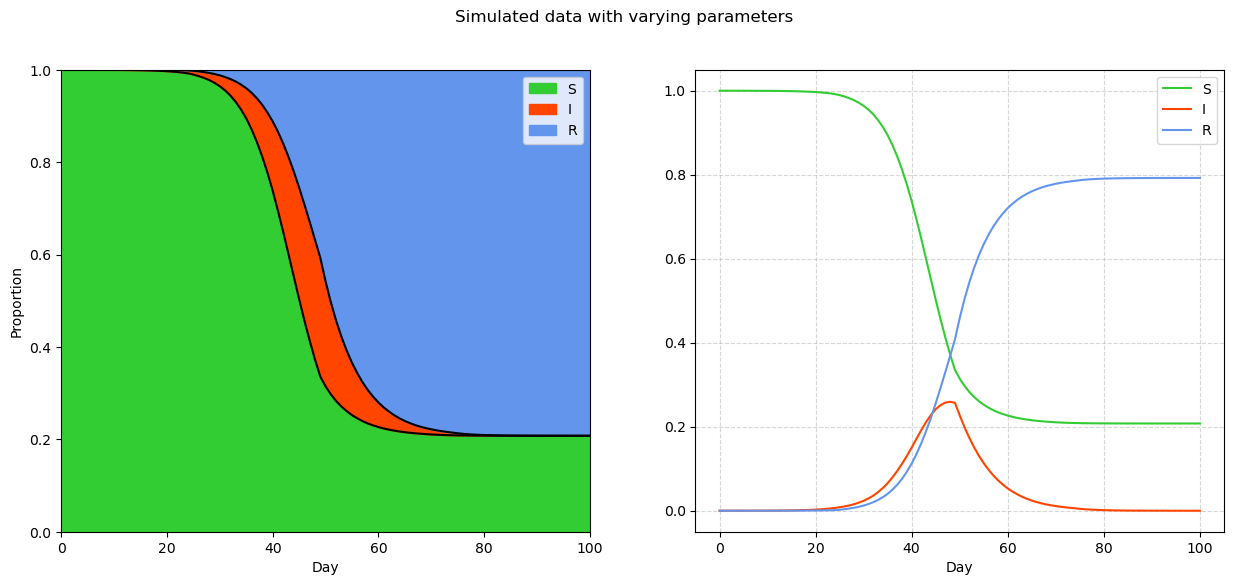

In [3]:
SIR_model.simulation()

## Full run on simulated data

In [4]:
n_steps = 25_000
p = 0.01
T = T - 1
burnin = 5_000
thin = 10

SIR_model.run(p, n_steps, burnin, thin)

Updating beta, gamma and delta parameters...


Buffering...:   0%|          | 0/25000 [00:00<?, ?it/s]

## Bayesian estimators

In [5]:
deltas_samples = SIR_model.deltas_samples
bs_samples = SIR_model.bs_samples
rs_samples = SIR_model.rs_samples
betas_samples = SIR_model.betas_samples
gammas_samples = SIR_model.gammas_samples

## Find Bayes estimator $\hat{\delta}$

In [6]:
SIR_model.find_Bayes_delta()
delta_final = SIR_model.delta_final

Finding best delta minimizing the loss...


Loading...:   0%|          | 0/100 [00:00<?, ?it/s]

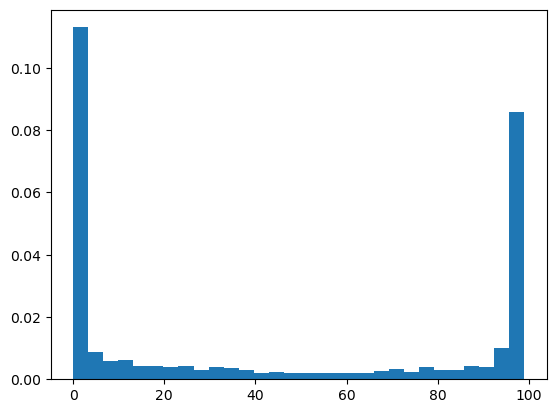

In [10]:
where = np.where(deltas_samples == 1)[0]
plt.hist(where, bins = 30, density=True);

In [7]:
delta_final

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [11]:
np.where(delta_final == 1)[0]

(array([ 0,  3, 97, 99], dtype=int64),)

In [8]:
SIR_model.ARI(delta_final, np.array(([1]+[0]*24)*4))

0.0031234919938559454

In [9]:
SIR_model.MI(delta_final, np.array(([1]+[0]*24)*4))

0.058015779778444736

In [15]:
np.exp(-(betas*SIR_model.configurations[:, 1]/N))

array([0.999985  , 0.9999808 , 0.9999754 , 0.9999676 , 0.9999583 ,
       0.9999505 , 0.9999367 , 0.9999184 , 0.99989051, 0.99986711,
       0.99983201, 0.99978402, 0.99973124, 0.99965386, 0.99956   ,
       0.99945625, 0.99932223, 0.99915136, 0.99894186, 0.99868057,
       0.99836274, 0.99797316, 0.99746941, 0.99681578, 0.99606755,
       0.99346226, 0.99188312, 0.9899445 , 0.98764535, 0.9848263 ,
       0.98133833, 0.9773262 , 0.97272798, 0.96728084, 0.96121343,
       0.95424006, 0.94683465, 0.93922708, 0.93150809, 0.92405545,
       0.91727129, 0.91144575, 0.90674574, 0.90338433, 0.90154727,
       0.90117555, 0.90248284, 0.90492863, 0.90836264, 0.9125719 ,
       0.9520157 , 0.95878373, 0.96467261, 0.96977834, 0.97422841,
       0.97812677, 0.98136212, 0.98424764, 0.98668864, 0.98876855,
       0.99048728, 0.99198752, 0.9932546 , 0.99428291, 0.99519757,
       0.9959669 , 0.99661175, 0.99717151, 0.99762882, 0.99799152,
       0.99833189, 0.99859199, 0.99881021, 0.999005  , 0.99915